# Model Performance


## Prerequisites
Install python packages

In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn segmentationmetrics requests

## Import required python packages

In [2]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import requests
import zipfile
import subprocess
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import segmentationmetrics as sm
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
import seaborn as sns
from tqdm.auto import tqdm

sns.set_theme(style="whitegrid")
%matplotlib inline

# Download the segmentation results from zenodo

In [4]:
qa_dir = Path("qa-results")

In [5]:
def download_inference(
    extract_dir="qa-results",
    record='12734644',filename = 'prostate-mr.zip'
):
    url=f"https://zenodo.org/record/{record}/files/{filename}",
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [6]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

In [7]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    image = result.segment_image(label)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, series_uid, label_value=1, version="aimiv2", label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
            m._surface_dist, 7
        ),
        "SeriesUID": series_uid,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics

In [8]:
# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv"))
qa_df = df[df.Validation]

# Paths for aimiv1, aimiv2, and qa
ai_path = Path("qa-results/ai-segmentations-dcm")
qa_path = Path("qa-results/qa-segmentations-dcm")

# Initialize lists for metrics
metrics = []

# Iterate over all QA cases
for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
    ai_file = ai_path / row.AISegmentation
    if not pd.isna( row.CorrectedSegmentation):
        qa_file = qa_path / row.CorrectedSegmentation
    else:
        # reviewer had no corrections, use AI segmentation as QA
        qa_file = ai_file

    assert ai_file.exists(), f"AI segmentation not found for {row.AISegmentation}"
    assert qa_file.exists(), f"QA segmentation not found for {row.QASegmentation}"

    version = 'aimiv1' if row.AimiProjectYear == 2023 else 'aimiv2'
    metrics.append(
        calc_metrics_for_label(
                ai_file, qa_file, row.SeriesInstanceUID, version=version, label_value=1
            )
        )

metrics_df = pd.DataFrame(metrics)

# Replace infinite values with NaN and drop NaN values
metrics_df = metrics_df.replace([np.inf, -np.inf], np.nan).dropna()


100%|██████████| 149/149 [00:17<00:00,  8.63it/s]


In [9]:

# Group by 'label' and 'version' and aggregate metrics
aggregated_df = (
    metrics_df.groupby(["label", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "mean_surface_distance_tol_7": ["mean", "std"],
        }
    )
    .round(2)
)

aggregated_df

dice       hausdorff_distance_95       mean_surface_distance  \
               mean   std                  mean   std                  mean   
label version                                                                 
1     aimiv1   1.00  0.00                  0.00  0.00                  0.00   
      aimiv2   0.99  0.02                  1.07  1.24                  0.15   

                    mean_surface_distance_tol_7       
                std                        mean  std  
label version                                         
1     aimiv1   0.00                         1.0  0.0  
      aimiv2   0.18                         1.0  0.0

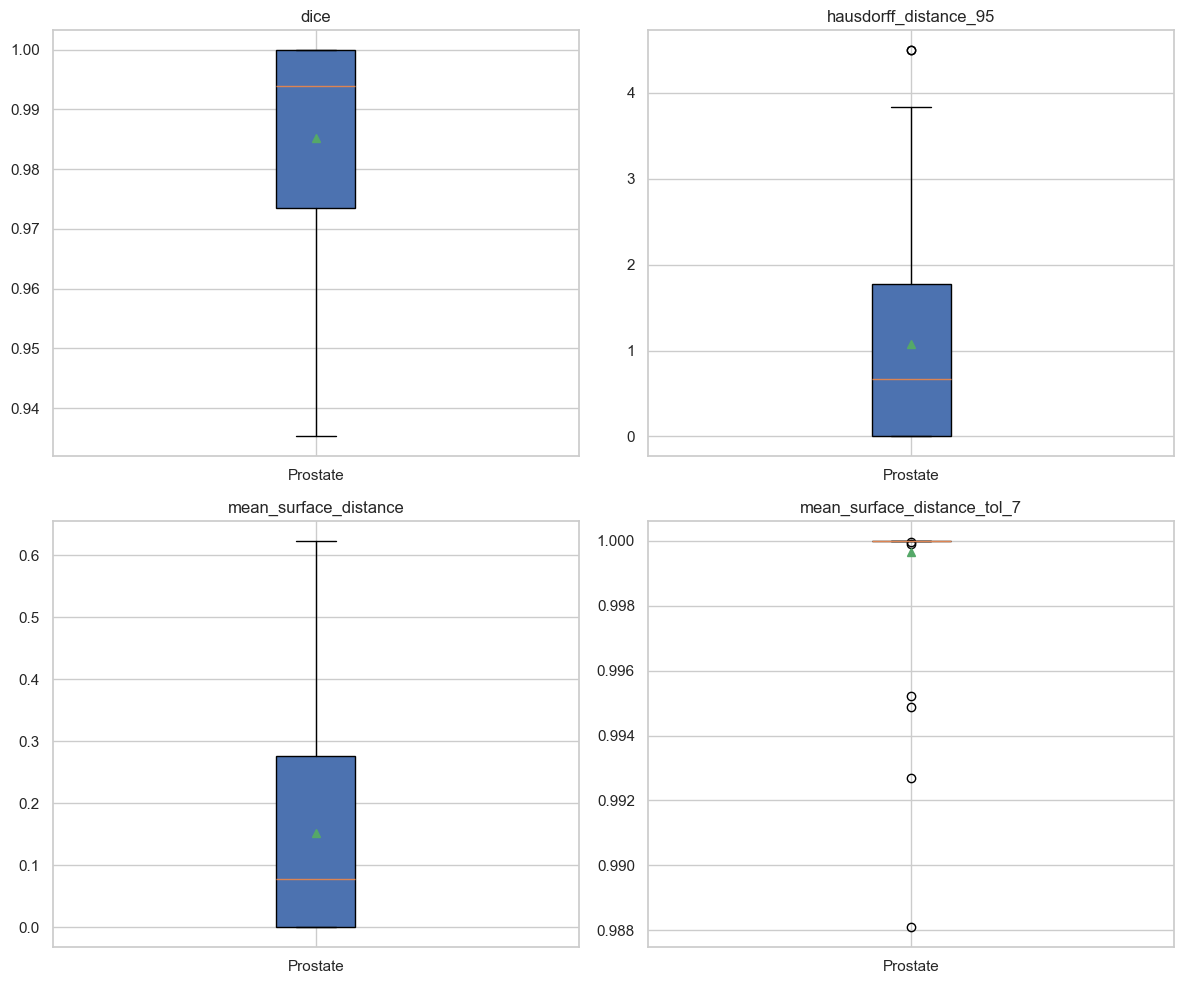

In [10]:
aimiv2_label1_df = metrics_df[(metrics_df.label == 1) & (metrics_df.version == 'aimiv2')]

# Create a figure and axis for subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# List of metrics to plot
metrics = [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "mean_surface_distance_tol_7",
]

# Plot each metric
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Extract data for current metric
    label1_data = aimiv2_label1_df[metric]

    # Check if label2_data has values and is not empty
    if not label1_data.empty:
        # Convert data to numeric if necessary
        label1_data = pd.to_numeric(label1_data, errors="coerce")

        # Drop NaN values if any (optional)
        label1_data = label1_data.dropna()

        # Check if after dropping NaN, there's still data
        if not label1_data.empty:
            # Create boxplots side by side
            ax.boxplot([label1_data], patch_artist=True, showmeans=True)
            ax.set_title(f"{metric.split('aimiv2_')[-1]}")
            ax.set_xticklabels(
                ["Prostate"]
            )  # Update x-axis labels to "Lesions"
        else:
            # Handle case where data might be dropped to empty
            print(f"No valid data available for {metric} after cleaning.")
    else:
        # If label2_data is empty, handle accordingly (e.g., print a message)
        print(f"No data available for {metric} in label2 (Lesions).")

# Adjust layout
plt.tight_layout()
plt.show()